In [1]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D #For 3D Plots

#Required by Jupyter for inlining images
%matplotlib inline

Read the Data:

In [3]:
Data = pd.read_pickle('../Data/Beam2_MergedRawData.pkl')

In [4]:
Data.head()

,Time Stamp Abort Gap,Abort Gap Reading,Time Stamp SPS,Time Stamp LHC,LHC-SPS,Time Stamp BLM,BLM,Time Stamp BPM,BPM Reading 1,BPM Reading 2,...,BPM Reading 16,BPM Reading 17,BPM Reading 18,BPM MSE,Time Stamp Bunches,Number of Bunches,Change in Number of Bunches,normBLM,normLHC-SPS,normAbort Gap Reading
0,1.534476e+09,6.693859e+08,1.534476e+09,1.534476e+09,-1.583225e+10,1.534476e+09,0.000007,1.534476e+09,-0.316,1.542,...,-0.468,-0.138,-0.468,0.007609,1.534476e+09,109.0,96.0,7.750417e-08,-1.649192e+08,6.972770e+06
1,1.534476e+09,2.435535e+09,1.534476e+09,1.534476e+09,1.862191e+10,1.534476e+09,0.000004,1.534476e+09,-0.341,1.545,...,-0.378,-0.142,-0.378,0.009360,1.534476e+09,121.0,12.0,3.461500e-07,1.551826e+09,2.029612e+08
2,1.534476e+09,8.187105e+08,1.534476e+09,1.534476e+09,4.101908e+09,1.534476e+09,0.000006,1.534476e+09,-0.285,1.523,...,-0.375,-0.056,-0.375,0.018102,1.534476e+09,133.0,12.0,5.215250e-07,3.418257e+08,6.822587e+07
3,1.534477e+09,1.870090e+08,1.534477e+09,1.534477e+09,9.793917e+09,1.534477e+09,0.000006,1.534477e+09,-0.300,1.311,...,-0.273,-0.139,-0.273,0.035793,1.534477e+09,145.0,12.0,4.909167e-07,8.161597e+08,1.558408e+07
4,1.534477e+09,-1.265663e+09,1.534477e+09,1.534477e+09,-3.154062e+10,1.534477e+09,0.000009,1.534477e+09,-0.297,1.157,...,-0.292,-0.207,-0.292,0.049792,1.534477e+09,289.0,144.0,6.561319e-08,-2.190321e+08,-8.789328e+06


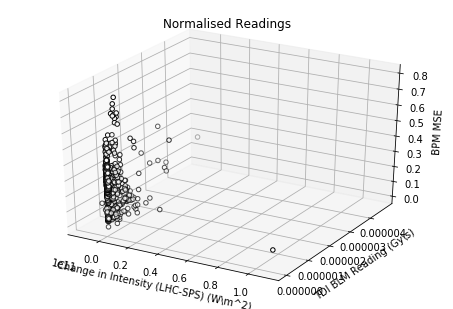

In [18]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(Data['normLHC-SPS'],Data['normBLM'],Data['BPM MSE'],c='white',
                edgecolor='k', s=20)
ax.set_xlabel('Change in Intensity (LHC-SPS) (W\m^2)')
ax.set_ylabel('TDI BLM Reading (Gy\s)')
ax.set_zlabel('BPM MSE')
ax.set_title('Normalised Readings')
plt.show()

### Remove Outliers

In [5]:
Data = Data.replace([np.inf, -np.inf], np.nan).dropna()

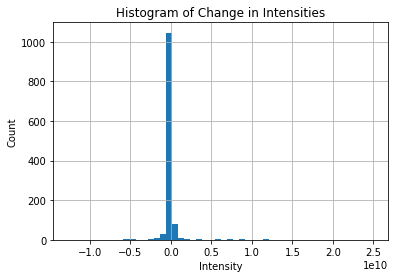

In [6]:
#cond = Data['normLHC-SPS']>-2e13
cond = Data['normLHC-SPS']<0.8e11
data =Data[cond]
plt.figure()
data['normLHC-SPS'].hist(bins = 50)
plt.title('Histogram of Change in Intensities')
plt.ylabel('Count')
plt.xlabel('Intensity')
plt.savefig('../Dissertation/images/Histogram_of_Change_in_Intensities_B2')

In [7]:
len(Data['normLHC-SPS'])

1212

### Scaling the Data

In [21]:
from sklearn.preprocessing import StandardScaler

In [22]:
features = ['normAbort Gap Reading','normLHC-SPS','normBLM','BPM MSE','BPM Reading 1','BPM Reading 2','BPM Reading 3','BPM Reading 4',
           'BPM Reading 5','BPM Reading 6','BPM Reading 7','BPM Reading 8','BPM Reading 9','BPM Reading 10',
           'BPM Reading 11','BPM Reading 12','BPM Reading 13','BPM Reading 14','BPM Reading 15','BPM Reading 16',
           'BPM Reading 17','BPM Reading 18','Change in Number of Bunches']
#Separate out the features
x = data.loc[:,features].values
x = StandardScaler().fit_transform(x)

In [23]:
x = pd.DataFrame(columns=features,data=x)

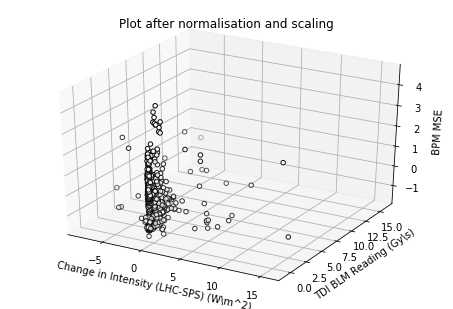

In [24]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(x['normLHC-SPS'],x['normBLM'],x['BPM MSE'],c='white',
                edgecolor='k', s=20)
ax.set_xlabel('Change in Intensity (LHC-SPS) (W\m^2)')
ax.set_ylabel('TDI BLM Reading (Gy\s)')
ax.set_zlabel('BPM MSE')
ax.set_title('Plot after normalisation and scaling')
plt.show()

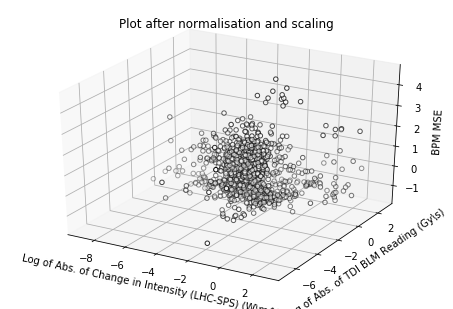

In [25]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(np.log(np.abs(x['normLHC-SPS'])),np.log(np.abs(x['normBLM'])),x['BPM MSE'],c='white',
                edgecolor='k', s=20)
ax.set_xlabel('Log of Abs. of Change in Intensity (LHC-SPS) (W\m^2)')
ax.set_ylabel('Log of Abs. of TDI BLM Reading (Gy\s)')
ax.set_zlabel('BPM MSE')
ax.set_title('Plot after normalisation and scaling')
plt.show()

### 3D LoF

In [26]:
from sklearn.neighbors import LocalOutlierFactor

In [43]:
df = pd.DataFrame(data ={'Change in Intensities':x['normLHC-SPS'],
                         'BLM':x['normBLM'],'BPM MSE':x['BPM MSE']} )

df.head()

,Change in Intensities,BLM,BPM MSE
0,-0.103053,-0.515569,-1.493332
1,0.965416,0.428207,-1.479977
2,0.212335,1.044315,-1.413300
3,0.507552,0.936785,-1.278358
4,-0.136732,-0.557343,-1.171578


In [49]:
lof = LocalOutlierFactor(n_neighbors=50, n_jobs=-1).fit_predict(df)

/home/marc/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


In [45]:
df['Predicted Value'] = lof
is_anomaly = df['Predicted Value']==-1
Anomalies = df[is_anomaly]

not_anomaly = df['Predicted Value']!=-1
Inliers = df[not_anomaly]

In [46]:
len(Anomalies['Predicted Value'])

122

In [47]:
data[data.index.isin(df[is_anomaly].index)].to_pickle(path='../Data/Beam2_Anomalies_from_3D_LoF.pkl')

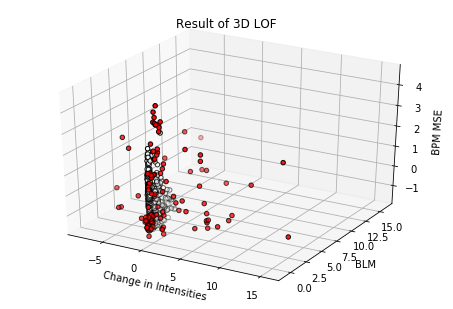

In [48]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(Anomalies['Change in Intensities'],Anomalies['BLM'],Anomalies['BPM MSE'],c='red',
                edgecolor='k', s=20)
ax.scatter(Inliers['Change in Intensities'],Inliers['BLM'],Inliers['BPM MSE'],c='white',
                edgecolor='k', s=20)
ax.set_xlabel('Change in Intensities')
ax.set_ylabel('BLM')
ax.set_zlabel('BPM MSE')
ax.set_title('Result of 3D LOF')
plt.savefig('../Dissertation/images/3D_LOF_Results')
plt.show()

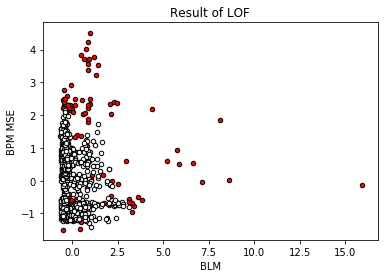

In [34]:
plt.figure()
plt.scatter(Anomalies['BLM'],Anomalies['BPM MSE'],c='red',
                edgecolor='k', s=20)
plt.scatter(Inliers['BLM'],Inliers['BPM MSE'],c='white',
                edgecolor='k', s=20)
plt.xlabel('BLM')
plt.ylabel('BPM MSE')
plt.title('Result of LOF')
plt.show()

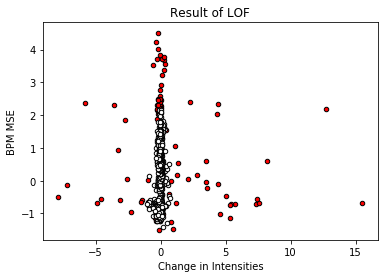

In [35]:
plt.figure()
plt.scatter(Anomalies['Change in Intensities'],Anomalies['BPM MSE'],c='red',
                edgecolor='k', s=20)
plt.scatter(Inliers['Change in Intensities'],Inliers['BPM MSE'],c='white',
                edgecolor='k', s=20)
plt.xlabel('Change in Intensities')
plt.ylabel('BPM MSE')
plt.title('Result of LOF')
plt.show()

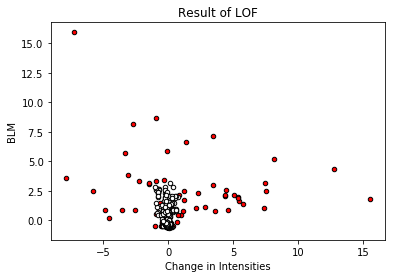

In [37]:
plt.figure()
plt.scatter(Anomalies['Change in Intensities'],Anomalies['BLM'],c='red',
                edgecolor='k', s=20)
plt.scatter(Inliers['Change in Intensities'],Inliers['BLM'],c='white',
                edgecolor='k', s=20)
plt.xlabel('Change in Intensities')
plt.ylabel('BLM')
#plt.yscale('log')
#plt.ylim(0,0.004)
plt.title('Result of LOF')
plt.show()

### LoF with all parameters

In [50]:
lof = LocalOutlierFactor(n_neighbors=50, n_jobs=-1).fit_predict(x)

/home/marc/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


In [51]:
x['Predicted Value'] = lof
is_anomaly = x['Predicted Value']==-1
Anomalies = x[is_anomaly]

not_anomaly = x['Predicted Value']!=-1
Inliers = x[not_anomaly]

In [52]:
len(Anomalies['normBLM'])

122

In [53]:
data[data.index.isin(x[is_anomaly].index)].to_pickle(path='../Data/Beam2_Anomalies_from_Full_LoF.pkl')

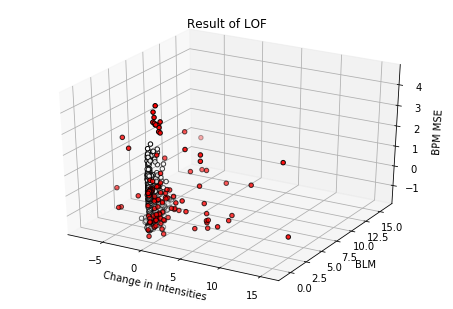

In [54]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(Anomalies['normLHC-SPS'],Anomalies['normBLM'],Anomalies['BPM MSE'],c='red',
                edgecolor='k', s=20)
ax.scatter(Inliers['normLHC-SPS'],Inliers['normBLM'],Inliers['BPM MSE'],c='white',
                edgecolor='k', s=20)
ax.set_xlabel('Change in Intensities')
ax.set_ylabel('BLM')
ax.set_zlabel('BPM MSE')
ax.set_title('Result of LOF')
plt.show()

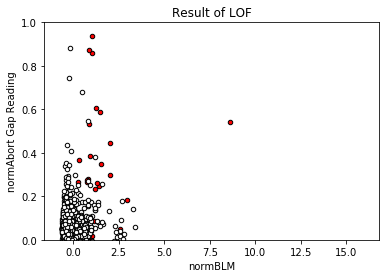

In [55]:
plt.figure()
plt.scatter(Anomalies['normBLM'],Anomalies['normAbort Gap Reading'],c='red',
                edgecolor='k', s=20)
plt.scatter(Inliers['normBLM'],Inliers['normAbort Gap Reading'],c='white',
                edgecolor='k', s=20)
plt.xlabel('normBLM')
plt.ylabel('normAbort Gap Reading')
#plt.yscale('log')
plt.ylim(0,1)
plt.title('Result of LOF')
plt.show()

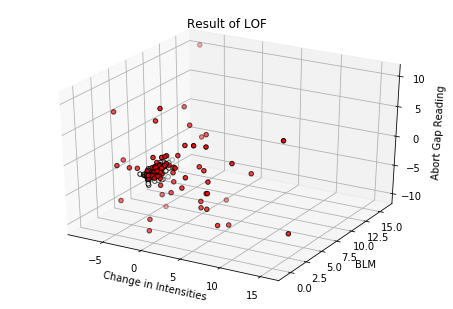

In [56]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(Anomalies['normLHC-SPS'],Anomalies['normBLM'],Anomalies['normAbort Gap Reading'],c='red',
                edgecolor='k', s=20)
ax.scatter(Inliers['normLHC-SPS'],Inliers['normBLM'],Inliers['normAbort Gap Reading'],c='white',
                edgecolor='k', s=20)
ax.set_xlabel('Change in Intensities')
ax.set_ylabel('BLM')
ax.set_zlabel('Abort Gap Reading')
ax.set_title('Result of LOF')
plt.show()

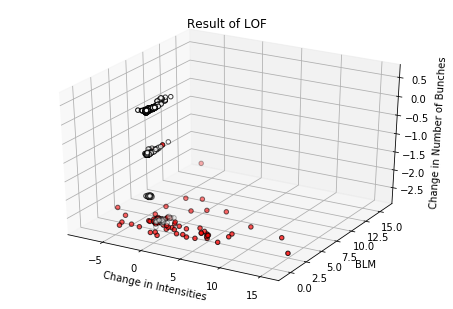

In [57]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(Anomalies['normLHC-SPS'],Anomalies['normBLM'],Anomalies['Change in Number of Bunches'],c='red',
                edgecolor='k', s=20)
ax.scatter(Inliers['normLHC-SPS'],Inliers['normBLM'],Inliers['Change in Number of Bunches'],c='white',
                edgecolor='k', s=20)
ax.set_xlabel('Change in Intensities')
ax.set_ylabel('BLM')
ax.set_zlabel('Change in Number of Bunches')
ax.set_title('Result of LOF')
plt.show()

### PCA:

In [58]:
from sklearn.decomposition import PCA

In [59]:
pca = PCA(n_components=0.95)

In [60]:
principalComponents = pca.fit_transform(x)
df = pd.DataFrame(data = principalComponents)
df.head()

,0,1,2,3,4,5,6,7,8
0,-4.525646,2.767953,1.685347,-0.304537,-1.726584,0.606196,-0.548853,-0.037712,0.463174
1,-2.364934,3.733819,2.635568,2.265032,-1.819614,1.964483,0.324839,1.793300,-1.194278
2,-2.489096,4.136096,2.868859,2.031873,-1.040197,1.156948,0.520897,0.106886,-0.732763
3,-0.791299,4.485949,1.757599,1.497686,-1.376847,0.527108,0.006198,0.020881,-0.924092
4,-1.970327,4.280336,-0.399945,-0.818300,-0.777343,0.292771,-1.788624,0.357493,0.381411


In [61]:
lof = LocalOutlierFactor(n_neighbors=20, n_jobs=-1).fit_predict(df)

/home/marc/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


In [62]:
df['Predicted Value'] = lof
is_anomaly = df['Predicted Value']==-1
Anomalies = df[is_anomaly]

not_anomaly = df['Predicted Value']!=-1
Inliers = df[not_anomaly]

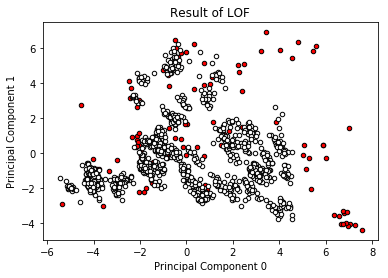

In [63]:
plt.figure()
plt.scatter(Anomalies[0],Anomalies[1],c='red',
                edgecolor='k', s=20)
plt.scatter(Inliers[0],Inliers[1],c='white',
                edgecolor='k', s=20)
plt.xlabel('Principal Component 0')
plt.ylabel('Principal Component 1')
#plt.ylim(0,0.004)
plt.title('Result of LOF')
plt.show()

In [64]:
len(Anomalies[0])

122

In [65]:
data[data.index.isin(df[is_anomaly].index)].to_pickle(path='../Data/Beam2_Anomalies_from_PCA_LoF.pkl')